In [1]:
## Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
stop = stopwords.words('english')
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.metrics import classification_report
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from string import punctuation
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import plotly.express as px
import spacy
import pickle
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import svm

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [52]:
## Loading the data
train = pd.read_csv('Data/train.csv', encoding='unicode_escape')
train.shape

(27481, 10)

In [53]:
train['text'][10]

' as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff'

In [54]:
test = pd.read_csv('Data/test.csv', encoding='unicode_escape')
test.shape

(4815, 9)

In [55]:
train['Feature'] = train['text'] ## Extracting text

In [56]:
test['Feature'] = test['text']

In [57]:
Y_train = train['sentiment'] ## Extracting sentiment
Y_train[:5]

0     neutral
1    negative
2    negative
3    negative
4    negative
Name: sentiment, dtype: object

In [58]:
Y_train.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [59]:
test['text'][15]

'So hot today =_=  don`t like it and i hate my new timetable, having such a bad week'

In [61]:
stuff_to_be_removed = list(punctuation)

In [62]:
## Text Cleaning Function
def textprocessing(text):
    text = str(text)
    text = text.lower() #converting all uppercase letters to lowercase
    text = re.sub(r"https\S+|www\S+|https\S+"," ",text,flags=re.MULTILINE) #removing all links from dataset
    text=re.sub("(\\d|\\W)+"," ",text)       
    text = re.sub(r'\@\w+|\#'," ",text) #removing # and @ symbols from dataset
    text = re.sub(r'[^\w\s\`]'," ",text) #removing other symbols like ^ except '
    text_tokens = word_tokenize(text) 
    lem = SnowballStemmer("english")
    text = [lem.stem(word) for word in text_tokens if not word in stuff_to_be_removed] 
    text1 = " ".join(text)
    return text1 

In [63]:
## preprocess if and only if text is not null
train['Feature_Clean'] = train['Feature'].apply(lambda x: textprocessing(x) if pd.notnull(x) else x)

In [64]:
test['Feature_Clean'] = test['Feature'].apply(lambda x: textprocessing(x) if pd.notnull(x) else x)

In [66]:
len(test[test['Feature_Clean'].isnull()].index.tolist())

1281

In [15]:
for i in test[test['Feature_Clean'].isnull()].index.tolist():
    test = test.drop(i) ## Removing NULL Values

In [16]:
## Finding the index of the text that is null
train[train['Feature_Clean'].isnull()].index.tolist()

[314]

In [17]:
Y_train[314]

'neutral'

In [18]:
## Removing the index 314 of the training data
train = train.drop(314)

In [19]:
X_train = train['Feature_Clean']
Y_train = train['sentiment']

In [20]:
X_test = test['Feature_Clean']
Y_test = test['sentiment']

In [21]:
Y_train.shape

(27480,)

In [22]:
## Distribution of the sentiment labels
Y_train.value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

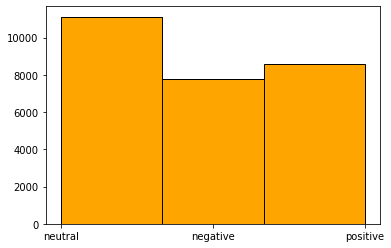

In [23]:
## Histogram
plt.hist(Y_train, bins=3, color='orange', edgecolor='black')
plt.show()
## Dataset more or less balanced

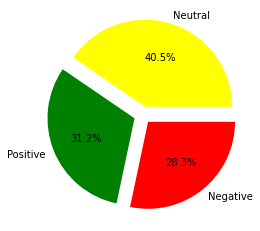

In [24]:
## Pie chart
labels = ['Neutral', 'Positive', 'Negative']
sizes = [Y_train.value_counts()[0], Y_train.value_counts()[1], Y_train.value_counts()[2]]
colors = ['Yellow', 'Green', 'Red']
explode = (0.1, 0.1, 0.1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.show()
## Dataset more or less balanced with different labels

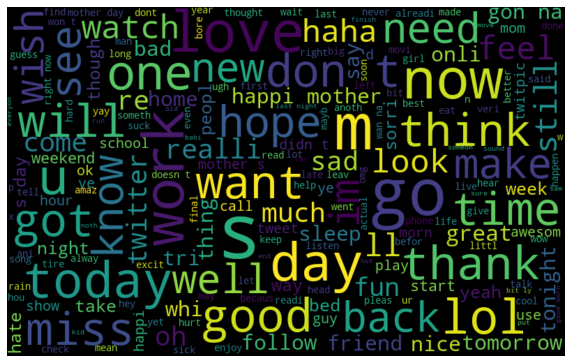

In [25]:
## Word Cloud for the entire dataset
all_words = ' '.join([text for text in train['Feature_Clean']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

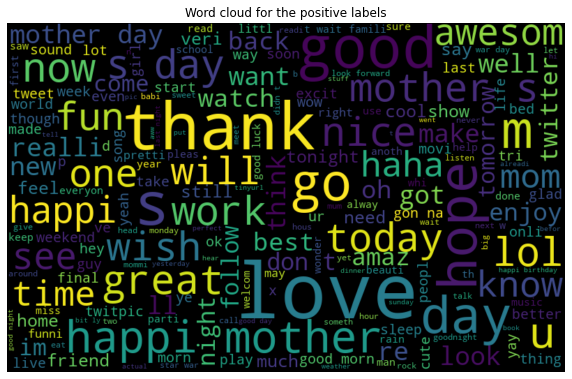

In [67]:
## Word cloud for the positive labels
all_words = ' '.join([text for text in train['Feature_Clean'][train['sentiment'] == 'positive']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.title('Word cloud for the positive labels')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

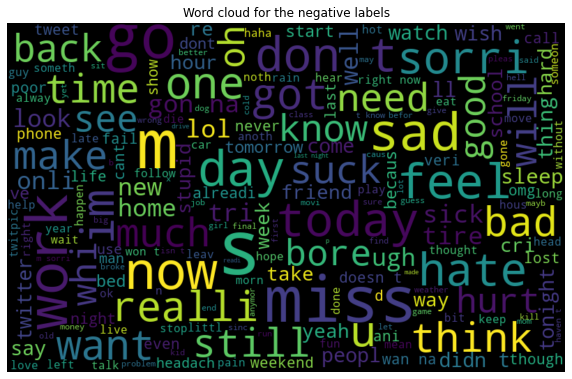

In [68]:
## Word cloud for the negative labels
all_words = ' '.join([text for text in train['Feature_Clean'][train['sentiment'] == 'negative']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.title('Word cloud for the negative labels')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [28]:
## Top 2-gram word combination with their frequencies
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), max_features=2000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(train['Feature_Clean'], 20)
## Bubble plot for the top n words
df = pd.DataFrame(common_words, columns=['Feature_Clean', 'count'])
fig = px.scatter(df, x='Feature_Clean', y='count', size='count', color='count', hover_name='Feature_Clean', size_max=60)
fig.show()

In [36]:
# ## Saving the cleaned Data
# df = pd.DataFrame()
# df['text'] = train['Feature_Clean']
# df['sentiment'] = train['sentiment']
# df.to_csv('Train.csv', header=True, index=False)

# df = pd.DataFrame()
# df['text'] = X_test
# df['sentiment'] = Y_test
# df.to_csv('Test.csv', header=True, index=False)

In [29]:
## Loading the cleaned data
train = pd.read_csv('Clean Data/Train.csv', encoding='unicode_escape')
train.shape

(27480, 2)

In [31]:
X_train = train['text']
Y_train = train['sentiment']

In [32]:
test = pd.read_csv('Clean Data/Test.csv', encoding='unicode_escape')
test.shape

(3534, 2)

In [33]:
X_test = test['text']
Y_test = test['sentiment']

In [34]:
# ## Count Vectorizer
# cv = CountVectorizer()
# X_train_cv = cv.fit_transform(X_train)
# X_test_cv = cv.transform(X_test)

In [8]:
## Word Embeddings of the train data using spacy model
nlp = spacy.load('en_core_web_sm')
X_train = X_train.apply(lambda x: nlp(x).vector)
X_train = np.array(X_train.tolist())
print("Training :", X_train.shape)

## Test vectors
X_test = X_test.apply(lambda x: nlp(x).vector)
X_test = np.array(X_test.tolist())
print("Test :", X_test.shape)

Training : (27480, 96)
Test : (3534, 96)


In [10]:
## Storing the X_train and Y_train separately in pickle file
pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()
## Test
pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

In [29]:
## Using Gensim model to create the embeddings on X_train and X_test
## Creating the embeddings
model = gensim.models.Word2Vec(X_train)
## Saving the model
model.save("word2vec_train.model")

In [30]:
## Creating the embeddings for the test set
model = gensim.models.Word2Vec(X_test)
## Saving the model
model.save("word2vec_test.model")

In [29]:
## Encoding the training labels
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_test = encoder.transform(Y_test)

In [31]:
## Text vectorization using TF-IDF
tfidf = TfidfVectorizer(max_features=2500)
X_train_tfidf = tfidf.fit_transform(X_train)
X_train_tfidf.shape

(27480, 2500)

In [32]:
## TF-IDF Transformation
X_test_tfidf = tfidf.transform(X_test)

In [33]:
## Model 1
## Naive Bayes Classifier
classifier1 = MultinomialNB()
classifier1.fit(X_train_tfidf, Y_train)
Y_pred1 = classifier1.predict(X_test_tfidf)
print(classification_report(Y_test, Y_pred1))

              precision    recall  f1-score   support

           0       0.76      0.54      0.63      1001
           1       0.59      0.81      0.68      1430
           2       0.80      0.62      0.70      1103

    accuracy                           0.67      3534
   macro avg       0.72      0.66      0.67      3534
weighted avg       0.70      0.67      0.67      3534



In [34]:
## Model 2
## Gaussian Naive Bayes
classifier2 = GaussianNB()
classifier2.fit(X_train_tfidf.toarray(), Y_train)
## Testing our model
Y_pred = classifier2.predict(X_test_tfidf.toarray())
## Classification report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.54      0.62      0.58      1001
           1       0.49      0.12      0.19      1430
           2       0.43      0.80      0.56      1103

    accuracy                           0.47      3534
   macro avg       0.49      0.51      0.44      3534
weighted avg       0.49      0.47      0.42      3534



In [35]:
## Model 3
## SVM
classifier3 = svm.SVC(kernel='linear', C=1, gamma=1)
classifier3.fit(X_train_tfidf, Y_train)
## Testing our model
Y_pred = classifier3.predict(X_test_tfidf)
## Classification report
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70      1001
           1       0.67      0.78      0.72      1430
           2       0.82      0.73      0.77      1103

    accuracy                           0.73      3534
   macro avg       0.74      0.72      0.73      3534
weighted avg       0.74      0.73      0.73      3534



In [38]:
## Model 4
## LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.utils import to_categorical

In [14]:
## load the pickle files
pickle_in = open("Spacy Vectors/X_train.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open("Spacy Vectors/X_test.pickle","rb")
X_test = pickle.load(pickle_in)

In [39]:
# # Define the LSTM model
# model = Sequential()
# model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(32))
# model.add(Dense(3, activation='softmax'))
# print(model.summary())

# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [22]:
# # Reshape the input data to match the expected input shape of the LSTM
# X_train_reshaped = np.expand_dims(X_train, axis=-1)
# X_val_reshaped = np.expand_dims(X_test, axis=-1)

In [23]:
# Y_train = to_categorical(Y_train)
# Y_test = to_categorical(Y_test)

In [40]:
# # Train the model
# model.fit(X_train_reshaped, Y_train, epochs=10, batch_size=32, validation_data=(X_val_reshaped, Y_test))

In [48]:
## Tokenizing the text
tokenizer = Tokenizer(num_words=1500, split=' ')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train)
X_train.shape

In [42]:
## Defining model parameters
embed_dim = 256
lstm_out = 196
batch_size = 32

## Defining the model with gensim vectors as X_train and X_test
model = Sequential()
model.add(Embedding(2500, embed_dim, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 256)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 35, 256)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               355152    
                                                                 
 dense (Dense)               (None, 3)                 591       
                                                                 
Total params: 995,743
Trainable params: 995,743
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
## converting y_train to categorical values
Y_train = to_categorical(Y_train)
Y_train.shape

(27480, 3)

In [44]:
## Training the model
model.fit(X_train, Y_train, epochs=10, batch_size=batch_size, verbose=2)

Epoch 1/10
859/859 - 106s - loss: 0.7714 - accuracy: 0.6594 - 106s/epoch - 123ms/step
Epoch 2/10
859/859 - 90s - loss: 0.6142 - accuracy: 0.7483 - 90s/epoch - 104ms/step
Epoch 3/10
859/859 - 99s - loss: 0.5624 - accuracy: 0.7724 - 99s/epoch - 116ms/step
Epoch 4/10
859/859 - 113s - loss: 0.5225 - accuracy: 0.7906 - 113s/epoch - 131ms/step
Epoch 5/10
859/859 - 102s - loss: 0.4875 - accuracy: 0.8037 - 102s/epoch - 119ms/step
Epoch 6/10
859/859 - 111s - loss: 0.4522 - accuracy: 0.8198 - 111s/epoch - 129ms/step
Epoch 7/10
859/859 - 106s - loss: 0.4188 - accuracy: 0.8340 - 106s/epoch - 123ms/step
Epoch 8/10
859/859 - 99s - loss: 0.3842 - accuracy: 0.8499 - 99s/epoch - 116ms/step
Epoch 9/10
859/859 - 100s - loss: 0.3531 - accuracy: 0.8621 - 100s/epoch - 117ms/step
Epoch 10/10
859/859 - 102s - loss: 0.3239 - accuracy: 0.8728 - 102s/epoch - 119ms/step


In [45]:
## Prediction
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])
Y_pred = model.predict(X_test)

111/111 [==============================] - 2s 15ms/step


In [46]:
## Classification Report
Y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1001
           1       0.70      0.66      0.68      1430
           2       0.78      0.79      0.78      1103

    accuracy                           0.72      3534
   macro avg       0.72      0.73      0.72      3534
weighted avg       0.72      0.72      0.72      3534



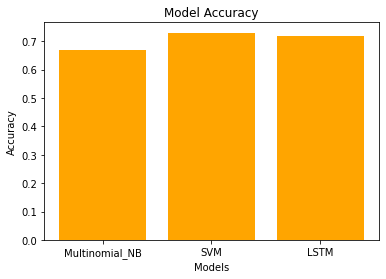

In [2]:
## plot of model accuracies that we got
x = ['Multinomial_NB', 'SVM', 'LSTM']
y = [0.67, 0.73, 0.72]
## Histogram of x and y
plt.bar(x, y, color='orange')
plt.title('Model Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()